In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy
from z3 import *
#set_param("parallel.enable",True)

In [2]:
def sol_print(solution):
    x= np.ones((3,3))
    groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    x = np.array(solution.astype('int').astype('str'))
    x[x=="0"] ="-"
    ax = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",vmin=0,vmax=19,linewidths=1,annot_kws={"size":10})
    ax.axis("off")    
    plt.tight_layout()
    plt.show()

In [3]:
fix = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 5, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 9, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0]])


sol =np.array([[2, 3, 6, 9, 4, 1, 8, 7, 5], 
               [9, 5, 4, 3, 7, 8, 6, 1, 2], 
               [8, 7, 1, 6, 2, 5, 4, 3, 9],  
               [1, 8, 2, 4, 3, 9, 7, 5, 6],
               [3, 9, 7, 8, 5, 6, 1, 2, 4],
               [6, 4, 5, 2, 1, 7, 3, 9, 8],
               [4, 1, 3, 5, 6, 2, 9, 8, 7],
               [5, 6, 9, 7, 8, 3, 2, 4, 1],
               [7, 2, 8, 1, 9, 4, 5, 6, 3]])

#fix= sol

rows = [4,33,20,17,26,10,16,24,0]
cols = [8,4,17,35,14,13,3,10,25,0] 

In [4]:
def solver(tactic,timeout):
    X = np.array(IntVector('x', 9*9),dtype=object).reshape(9,9)
    s = Tactic(tactic).solver()
    if tactic != 'qfnia':
        s.set("timeout", timeout)

    # numbers between 1 & 9
    s += [And(e > 0  ,e <=9) for (i,j),e in np.ndenumerate(X)]

    # rows & columns
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if i == n]) for n in range(9)])
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if j == n]) for n in range(9)])

    # groups
    x= np.ones((3,3))
    groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
    s += And([Distinct([e for (i,j),e in np.ndenumerate(X) if groups[i,j] == n]) for n in range(9)])

    # set fixed
    s += And([e == int(fix[i,j]) for (i,j),e in np.ndenumerate(X) if fix[i,j] != 0])  

    # sandwich 
    s += [And([Implies(Or(And(X[i,n] == 9,X[j,n] == 1),And(X[i,n] == 1,X[j,n] == 9)),sum(X[i+1:j,n]) == cols[n]) for i in range(9) for j in range(9) if j > i ]) for n in range(9)]
    s += [And([Implies(Or(And(X[n,i] == 9,X[n,j] == 1),And(X[n,i] == 1,X[n,j] == 9)),sum(X[n,i+1:j]) == rows[n]) for i in range(9) for j in range(9) if j > i ]) for n in range(9)]
    
    start = time.time()
    if s.check() == sat:
        m = s.model()
        print("{}: {} Solved in {:.4f} seconds".format(tactic,tactic_description(tactic),time.time()-start))
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        r =  evalu(X)
        sol_print(r)
    else:
        print("{}:{} failed in {:.4f} seconds".format(tactic,tactic_description(tactic),time.time()-start))

qffd: builtin strategy for solving QF_FD problems. Solved in 7.4930 seconds


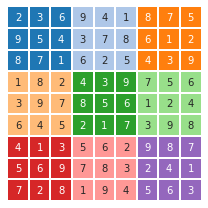

In [5]:
solver('qffd',10000)

qfnia: builtin strategy for solving QF_NIA problems. Solved in 18.7639 seconds


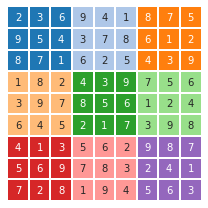

In [6]:
solver('qfnia',60000*5)

pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 2.7167 seconds


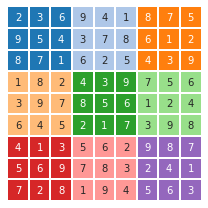

In [7]:
solver('pqffd',10000)

In [8]:
solver('psmt',60000*15)

psmt:builtin strategy for SMT tactic in parallel. failed in 900.1823 seconds


smt: apply a SAT based SMT solver. Solved in 874.4716 seconds


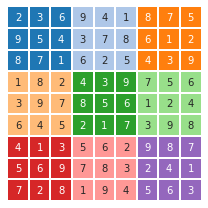

In [9]:
solver('smt',60000*15)

In [10]:
t = tactics()
for i in t:
    if i not in ['smtfd','qffd','qfnia','pqffd','smt','psmt']:
        solver(i,5000)

ackermannize_bv:A tactic for performing full Ackermannization on bv instances. failed in 0.0000 seconds
subpaving:tactic for testing subpaving module. failed in 0.0120 seconds
horn:apply tactic for horn clauses. failed in 0.0040 seconds
horn-simplify:simplify horn clauses. failed in 0.0050 seconds
nlsat:(try to) solve goal using a nonlinear arithmetic solver. failed in 0.0000 seconds
qfnra-nlsat:builtin strategy for solving QF_NRA problems using only nlsat. failed in 5.3796 seconds
nlqsat:apply a NL-QSAT solver. failed in 0.0000 seconds
qe-light:apply light-weight quantifier elimination. failed in 0.0000 seconds
qe:apply quantifier elimination. failed in 0.0010 seconds
qsat:apply a QSAT solver. failed in 5.0126 seconds
qe2:apply a QSAT based quantifier elimination. failed in 5.0276 seconds
qe_rec:apply a QSAT based quantifier elimination recursively. failed in 0.0010 seconds
psat:(try to) solve goal using a parallel SAT solver. failed in 0.0000 seconds
sat:(try to) solve goal using a S

In [11]:
solver('smtfd',60000*5)

smtfd: builtin strategy for solving SMT problems by reduction to FD. Solved in 0.2553 seconds


AttributeError: 'ArithRef' object has no attribute 'as_long'